In [1]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=OPENAI_API_KEY
)

In [3]:
from typing import TypedDict

class EvalState(TypedDict):
    question: str
    answer: str
    score: float
    accepted: bool

In [4]:
def generate_node(state: EvalState) -> EvalState:
    prompt = f"""
Answer the following question clearly and concisely.

Question:
{state['question']}
"""

    response = llm.invoke(prompt)

    return {
        **state,
        "answer": response.content
    }

In [5]:
def evaluate_node(state: EvalState) -> EvalState:
    prompt = f"""
Evaluate the answer below on a scale from 0 to 10.

Criteria:
- Correctness
- Completeness
- Clarity

Answer:
{state['answer']}

Return only a number.
"""

    response = llm.invoke(prompt).content.strip()

    try:
        score = float(response)
    except ValueError:
        score = 0.0

    return {
        **state,
        "score": score,
        "accepted": score >= 7.0
    }

In [6]:
def refine_node(state: EvalState) -> EvalState:
    prompt = f"""
Improve the answer below based on the following evaluation score.

Score:
{state['score']}

Answer:
{state['answer']}
"""

    response = llm.invoke(prompt)

    return {
        **state,
        "answer": response.content
    }


In [7]:
def should_refine(state: EvalState) -> str:
    if state["accepted"]:
        return "end"
    return "refine"

In [8]:
from langgraph.graph import StateGraph, END

graph = StateGraph(EvalState)

graph.add_node("generate", generate_node)
graph.add_node("evaluate", evaluate_node)
graph.add_node("refine", refine_node)

graph.set_entry_point("generate")

graph.add_edge("generate", "evaluate")

graph.add_conditional_edges(
    "evaluate",
    should_refine,
    {
        "refine": "refine",
        "end": END
    }
)

graph.add_edge("refine", "evaluate")

app = graph.compile()

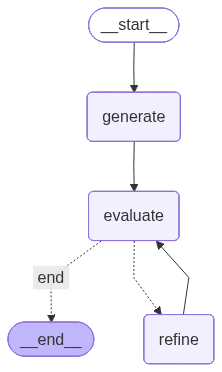

In [9]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [10]:
question = "is agentic ai the next big thing?"

initial_state: EvalState = {
    "question": question,
    "answer": "",
    "score": 0.0,
    "accepted": False
}

final_state = app.invoke(initial_state)

print("Answer:")
print(final_state["answer"])
print("\nScore:", final_state["score"])

Answer:
Agentic AI, which refers to AI systems that can act autonomously and make decisions based on their environment, is considered by many experts to be a significant advancement in the field of artificial intelligence. Its potential applications span various industries, including healthcare, finance, and autonomous vehicles. While it holds promise for transforming how tasks are performed and improving efficiency, the extent to which it will be the "next big thing" depends on advancements in technology, ethical considerations, regulatory frameworks, and public acceptance. Overall, it is likely to play a crucial role in the future of AI development.

Score: 8.0
